# Who Were The Nuns Analysis

Set up the program by importing the required modules and setting the file location

# Setup
Create Virtual Environment ```python3 -m venv venv_WWTN```
Mac: ```source venv_WWTN/bin/activate```
Windows - Call Activate.ps1

python3 -m pip install --upgrade pip
python3 -m pip install -r requirements.txt   

In [193]:
import os # To navigate the OS and read/save files
import re # Regular Expressions - to search for patterns in text
import datetime as dt
import pandas as pd 
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

wwtnImport = os.path.join(os.getcwd(), 'WWTNDatabase')

## Load data
For each of the files, load it into a dataframe of the same name.

In [194]:
def loadWWTN(folder,file):
    fileName = os.path.join(folder,file) + '.csv'
    df = pd.read_csv(fileName)
    return df

associated_people= loadWWTN(wwtnImport, 'associated_people')
convent= loadWWTN(wwtnImport, 'convent')
convents= loadWWTN(wwtnImport, 'convents')
creative_works= loadWWTN(wwtnImport, 'creative_works')
link_types= loadWWTN(wwtnImport, 'link_types')
linkages= loadWWTN(wwtnImport, 'linkages')    
locations= loadWWTN(wwtnImport, 'locations')    
notes= loadWWTN(wwtnImport, 'notes')   
nuns= loadWWTN(wwtnImport, 'nuns')
office= loadWWTN(wwtnImport, 'office')    
offices= loadWWTN(wwtnImport, 'offices')  
pdfs= loadWWTN(wwtnImport, 'pdfs')   
pdfxuids= loadWWTN(wwtnImport, 'pdfxuids')  
people= loadWWTN(wwtnImport, 'people')
people_places= loadWWTN(wwtnImport, 'people_places')   
places= loadWWTN(wwtnImport, 'places')    
professions= loadWWTN(wwtnImport, 'professions')    
quotes= loadWWTN(wwtnImport, 'quotes')    
relationships= loadWWTN(wwtnImport, 'relationships')    
religorders= loadWWTN(wwtnImport, 'religorders')    
srcdocs= loadWWTN(wwtnImport, 'srcdocs')    
srcrefs= loadWWTN(wwtnImport, 'srcrefs')    
srcxcids= loadWWTN(wwtnImport, 'srcxcids')    
srcxuids= loadWWTN(wwtnImport, 'srcxuids')    
variants= loadWWTN(wwtnImport, 'variants')

# Build a list of dates
Collate dates from each individual table into a singe central list
This allows the analysis and processing to be done in one place

## Nuns
Contains one record for each nun:
* date_birth Date of Birth
* date_death Date of death
Also captures the age at death

## Profession
Details of the nun professing at a convent. 
Not all nuns will have a record here (some did not profess)
Some will have multile records (they joined more than one order)
* Profession date
Also captures the age at profession

## Office
> 

* Office - Date from
* Office - Date until

## Convent
Stays at each convent
There are some nuns who stay at more than one convent. They will have multiple rows in this daaset - one for each convent.
There are some nuns recorded in the database, who were never members of an English convent – this is an anomaly
* Convent - Date from
* Convent - Date until

## Locations
* Date from
* Date to

In [195]:
# Nuns
births = nuns[['uid','date_birth']].copy()
births['event']= 'Birth'

deaths = nuns[['uid','date_death','age_death']].copy()
deaths['event'] = 'Death'

# Professions
professions = professions[['uid','ordid','date_profession','age_profession']].copy()
professions['event'] = 'Profession'

# Office
officeFrom = office[['uid','cid','officeid','date_from']].copy()
officeFrom.rename(columns = {'date_from':'date_office_from'}, inplace = True)
officeFrom['event'] = 'Took office'

leftOffice = office[['uid','cid','officeid','date_until']].copy()
leftOffice.rename(columns = {'date_until':'date_office_until'}, inplace = True)
leftOffice['event'] = 'Left office'

# Convent
conventEntry = convent[['uid','cid','date_from','age_entry']].copy()
conventEntry.rename(columns = {'date_from':'date_convent_from'}, inplace = True)
conventEntry['event'] = 'Arrived at Convent'

leftConvent = convent[['uid','cid','date_left']].copy()
leftConvent.rename(columns = {'date_left':'date_left_convent'}, inplace = True)
leftConvent['event'] = 'Left Convent'

locationFrom = locations[['cid','date_from']].copy()
locationFrom.rename(columns = {'date_from':'date_location_from'}, inplace = True)
locationFrom['event'] = 'Convent Location from'

locationTo = locations[['cid','date_to']].copy()
locationTo.rename(columns = {'date_to':'date_location_to'}, inplace = True)
locationTo['event'] = 'Convent Location to'

#Combine all date lists into one
eventDates = pd.concat([births, deaths, professions, officeFrom, leftOffice, conventEntry, leftConvent, locationFrom, locationTo])

# Set EventDate and EventAge
eventDates['eventDate'] = eventDates[['date_birth', 'date_death', 'date_profession','date_office_from','date_office_until','date_convent_from','date_left_convent','date_location_from','date_location_to']].bfill(axis=1).iloc[:, 0]
eventDates['eventAge'] = eventDates[['age_death','age_profession','age_entry']].bfill(axis=1).iloc[:, 0]

In [243]:
def tokenizeDate(dateStr:str):
    dateStr = str(dateStr)
    tok = dateStr.strip()

    # Replace multiple spaces with a single space
    tok = re.sub("\s\s+", " ", tok)

    # Replace month names, fragments of the name & standard abbreviations with a placeholder
    tok = re.sub(r'(January|February|March|April|May|June|July|August|September|October|November|December)','[MonthName]',tok, flags=re.IGNORECASE)
    tok = re.sub(r'(Sept|Apr|Ap)','[MonthPart]',tok, flags=re.IGNORECASE)
    tok = re.sub(r'(Jan|Feb|Mar|Apr|Jun|Jul|Aug|Sep|Oct|Nov|Dec)','[MonthAbbreviation]',tok, flags=re.IGNORECASE)

    tok = re.sub(r'([^a-z]c\b|\?)','~',tok, flags=re.IGNORECASE)
    
    tok = re.sub(r'(after|aft|aft.|\(at the earliest\))','->',tok, flags=re.IGNORECASE)
    tok = re.sub(r'(before|bef|by)','<-',tok, flags=re.IGNORECASE)

    # Year - Check for 16..
    tok = re.sub(r'1[5-8][0-9][0-9]','YYYY',tok, flags=re.IGNORECASE)

    tok = re.sub("Y\s~", "Y~", tok)
    tok = re.sub(r'[0-9]','#',tok, flags=re.IGNORECASE)

    return tok

eventDates['token'] = eventDates['eventDate'].apply(tokenizeDate)


                                                token  n
1                                      ## [MonthName]  1
2                                      ## [MonthPart]  1
5                         ###~ ## [MonthAbbreviation]  1
6                           ##- # [MonthAbbreviation]  1
7                              ##-[MonthAbbreviation]  1
8                                      ##-[MonthPart]  1
9                           ##~ # [MonthAbbreviation]  1
10                         ##~ ## [MonthAbbreviation]  1
14             YYYY # [MonthAbbreviation] (#rd order)  1
15                      YYYY # [MonthAbbreviation] ->  1
18          YYYY # [MonthAbbreviation]/ # [MonthPart]  1
19  YYYY # [MonthAbbreviation]/## [MonthAbbreviation]  1
22                             YYYY ## ## [MonthName]  1
25                 YYYY ## [MonthAbbreviation] prison  1
26  YYYY ## [MonthAbbreviation], YYYY ## [MonthAbb...  1
27  YYYY ## [MonthAbbreviation]/ # [MonthAbbreviat...  1
29  YYYY ## [MonthAbbreviation]

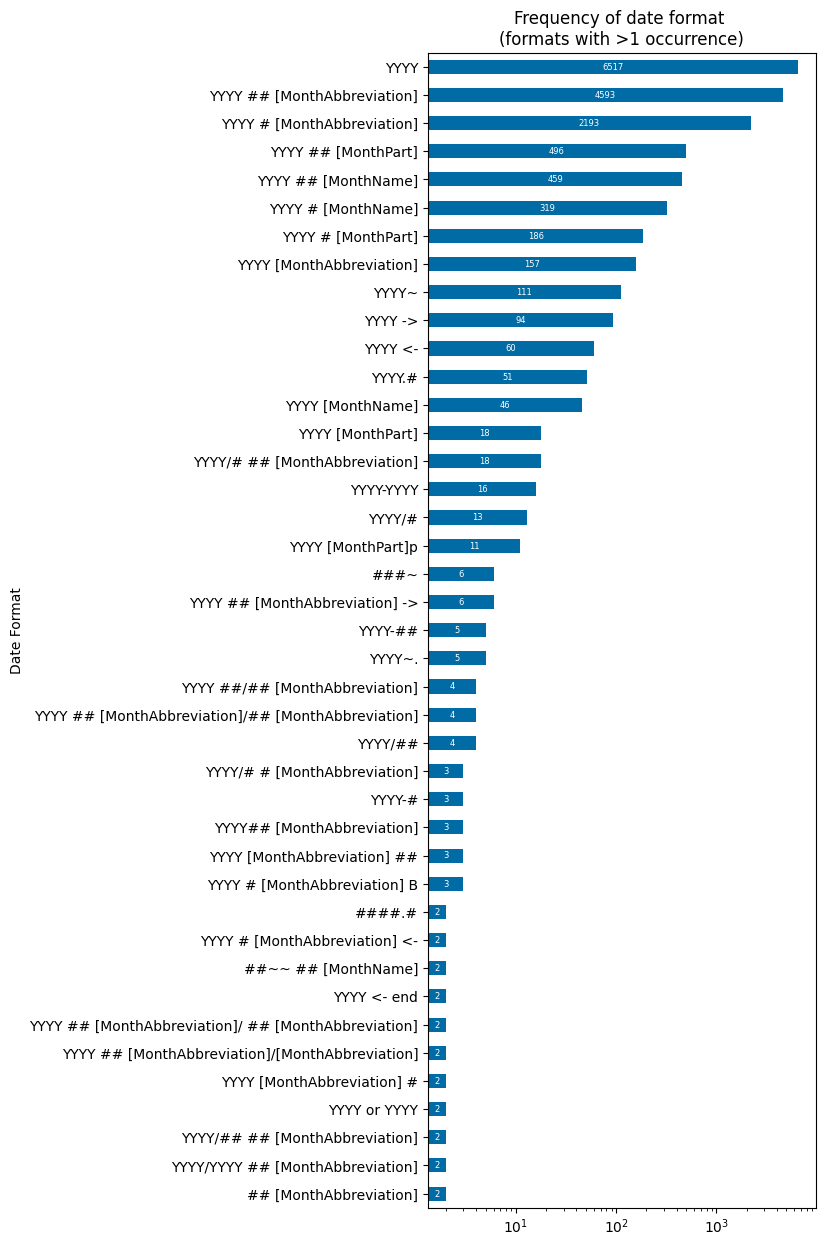

In [244]:
tokenCounts = eventDates.groupby('token')['token'].count().reset_index(name='n') 
plotData = tokenCounts[tokenCounts['n']>1]
plotData = plotData.sort_values(by = 'n', ascending = True)
plotData = plotData[plotData['token']!='nan']

matplotlib.style.use('tableau-colorblind10')
tokenPlot = plotData.plot.barh(x='token',y='n', logx=True
                                ,figsize=(5,15)
                                ,legend = False
                                ,title = 'Frequency of date format \n(formats with >1 occurrence)'
                                )
plt.ylabel(ylabel = 'Date Format',rotation=90)


tokenPlot.bar_label(tokenPlot.containers[0]
                    , label_type = 'center'
                    , color='w', fontsize=6)

print(tokenCounts[tokenCounts['n']==1])

In [232]:
def ParseDate(dateStr,token):
    yearMin, yearMax = None,None #dt.date.min.year(), dt.date.max.year()
    monthMin,monthMax = 1,12
    dayMin,dayMax = 1,31
    dateMin,dateMax = None,None
    qualifier = ''

    dateStr = str(dateStr)
    # Remove spaces & replace multiple spaces with a single space
    dateStr = dateStr.strip()
    dateStr = re.sub("\s\s+", " ", dateStr)

    qualifiers = []

    parts = dateStr.split()
    for part in parts:
        # Check for qualifiers e.g. circa, c., ?

        #Replace month variants with their standard short form

        # Replace month names, fragments of the name & standard abbreviations with a placeholder
        tok = re.sub(r'(January|February|March|April|May|June|July|August|September|October|November|December)','[MonthName]',tok, flags=re.IGNORECASE)
        tok = re.sub(r'(Sept|Apr|Ap)','[MonthPart]',tok, flags=re.IGNORECASE)
        tok = re.sub(r'(Jan|Feb|Mar|Apr|Jun|Jul|Aug|Sep|Oct|Nov|Dec)','[MonthAbbreviation]',tok, flags=re.IGNORECASE)

    if '~' in token:
        qualifier = 'approx.'

    yearMin = 0000
    yearMax = 2999

    # Get Years by splitting string - look for 4+digits +/- /-. +/- c, ? etc
    qualifiers = set(qualifiers)
    qualifier = ''.join(qualifiers)
    return pd.Series([yearMin,yearMax,monthMin,monthMax,dayMin,dayMax,qualifier,dateMin,dateMax]
                    ,index = ['yearMin','yearMax','monthMin','MonthMax','dayMin','dayMax','qualifier','dateMin','dateMax'])

samples = eventDates.groupby('token')['eventDate','token'].sample(1)
samples[['yearMin','yearMax'
        ,'monthMin','MonthMax'
        ,'dayMin','dayMax'
        ,'qualifier'
        ,'dateMin','dateMax']] = samples.apply(lambda row: ParseDate(row.eventDate, row.token), axis=1, result_type='expand')
samples

/var/folders/jb/j95rwfl16sn7sb9x0n4xnjdh0000gn/T/ipykernel_96034/1561318431.py:33: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  samples = eventDates.groupby('token')['eventDate','token'].sample(1)


,eventDate,token,yearMin,yearMax,monthMin,MonthMax,dayMin,dayMax,qualifier,dateMin,dateMax
2640,14 Jan,## [MonthAbbreviation],0,2999,1,12,1,31,,None,None
2737,10 May,## [MonthName],0,2999,1,12,1,31,,None,None
2738,10 Apr,## [MonthPart],0,2999,1,12,1,31,,None,None
2,1911.0,####.#,0,2999,1,12,1,31,,None,None
3182,17- 8 Mar,##- # [MonthAbbreviation],0,2999,1,12,1,31,,None,None
...,...,...,...,...,...,...,...,...,...,...,...
3471,1712? 13 May,YYYY~ ## [MonthName],0,2999,1,12,1,31,approx.,None,None
2629,1700 c 1 Jun,YYYY~# [MonthAbbreviation],0,2999,1,12,1,31,approx.,None,None
2736,1700 c 10 Jun,YYYY~## [MonthAbbreviation],0,2999,1,12,1,31,approx.,None,None
2702,1700 c 23 Apr,YYYY~## [MonthPart],0,2999,1,12,1,31,approx.,None,None


In [211]:
t = '1658/9  12 Apr'
t.split()
parseDate(t)

'YYYY/#  ## <MonthPart>'